In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from tkinter import filedialog
import seaborn as sns
import itertools
from colour import Color
from datetime import date
import tifffile
import scipy  as spy
from skimage import filters

In [2]:
today = date.today()
print("Today's date:", today)
date_today = str(today)
date_today

Today's date: 2023-02-22


'2023-02-22'

In [63]:
askfile = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the folder on ONE date you want to process
path = Path(askfile)
filename = path.stem
path, filename

(WindowsPath('C:/Users/Brouhard Lab/Dropbox/2023 Cruz Paquette Sebastien Brouhard DCX/sample_cell_1pix-0_1172um.tif'),
 'sample_cell_1pix-0_1172um')

## Background Substraction & Pseudo-FlatField ##

In [64]:
def background_substraction(image, median_size, gaussian_sigma):
    
    pxNo = 700

    median = [np.empty((pxNo,pxNo))]
    gaussian = [np.empty((pxNo,pxNo))]
    
    for i in np.arange(len(image)):
        
        median0 = spy.ndimage.median_filter(image[i], size=median_size)
        median = np.append(median, [median0],axis=0)

        gaussian0 = spy.ndimage.gaussian_filter(median0, sigma=gaussian_sigma)
        gaussian = np.append(gaussian, [gaussian0],axis=0)

    median = median[1:]
    gaussian = gaussian[1:]
    
    #sometimes a value in gaussian is bigger than in median, in which case the substraction acts module 16-bit and goes round to the highest value
    #this substitution makes sure the substraction goes to zero in those cases
    gaussian = np.where(gaussian > median, median, gaussian) 

    substract = median - gaussian
    
    substract = substract.astype(np.uint16)
    
    return substract

In [65]:
def pseudo_flatfield(substract, gaussian_sigma):
    pxNo = 700

    gaussian = [np.empty((pxNo,pxNo))]
    
    for i in np.arange(len(substract)):
        
        gaussian0 = spy.ndimage.gaussian_filter(substract[i], sigma=gaussian_sigma)
        gaussian = np.append(gaussian, [gaussian0],axis=0)

    gaussian = gaussian[1:]
    
    #this substitution makes sure it doesn't divide by zero
    gaussian = np.where(gaussian == 0, 1, gaussian) 
    
    pseudoFF = substract / gaussian
    
    pseudoFF = pseudoFF.astype(np.uint16)
    
    return pseudoFF

In [66]:
size=5
sigma=10

i = path
    
raw = tifffile.imread(i)
substract = background_substraction(raw, size, sigma)
pseudoFF = pseudo_flatfield(substract, sigma)

string_file =str(i)
path = i.parents[0]

tifffile.imsave(path/(filename+'_Composite.tif'), substract)
tifffile.imsave(path/(filename+'_CompositePFF.tif'), pseudoFF)

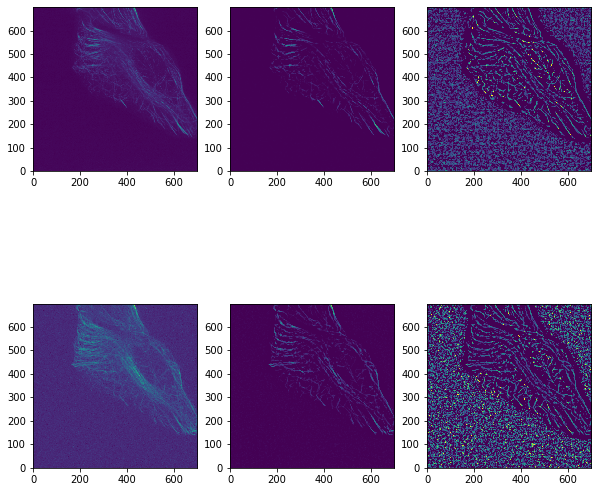

In [67]:
fig, ax = plt.subplots(2,3,figsize=(10,10))

ax[0,0].imshow(raw[0], interpolation='none', origin='lower', cmap='viridis')
ax[1,0].imshow(raw[1], interpolation='none', origin='lower', cmap='viridis')
ax[0,1].imshow(substract[0], interpolation='none', origin='lower', cmap='viridis')
ax[1,1].imshow(substract[1], interpolation='none', origin='lower', cmap='viridis')
ax[0,2].imshow(pseudoFF[0], interpolation='none', vmin=0, vmax=10, origin='lower', cmap='viridis')
ax[1,2].imshow(pseudoFF[1], interpolation='none', vmin=0, vmax=10, origin='lower', cmap='viridis')

# !!!User must drift correct image before continuing!!! #

Drift corrected file must be named: filename_CompositePFF-driftcorrected.tif 

## Otsu Processing ##

In [40]:
filename

'1-stack'

In [49]:
processed_files = []
j = path 
files0 = [x for x in j.iterdir() if x.is_file()]
files0 = [i for i in files0 if str(i).rfind(filename+'_CompositePFF-driftcorrected') != -1]
processed_files = processed_files + files0
processed_files

[WindowsPath('C:/Users/sofia/OneDrive/Documentos/2022_1winter/2022-02-28_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/1-stack_CompositePFF-driftcorrected.tif')]

In [47]:
askfile = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the folder on ONE date you want to process
path = Path(askfile)
filename = path.stem
processed_files = [path]
processed_files, filename

([WindowsPath('C:/Users/Brouhard Lab/Dropbox/2023 Cruz Paquette Sebastien Brouhard DCX/sample_cell_1pix-0_1172um_CompositePFF.tif')],
 'sample_cell_1pix-0_1172um_CompositePFF')

In [45]:
DCXconc = '[DCX] ' r'$(n M)$'
DCX = 'DCX'
Type = 'Type'
investigator = 'Sofia'

In [34]:
def acquire_metadata(processed_file_paths,investigator):

    ch = []
    imgNo = []
    conc_DCXGFP = []
    DCX_type = []
    dates = []
    
    n = len(processed_file_paths)

    for i in processed_file_paths:
        #get the file metadata
        CHstart = str(i).find('CH')
        CHend = str(i).find('_', CHstart)
        ch = ch + [str(i)[CHstart+2:CHend]]
        
        imgNostart = str(i).find('yes')
        imgNoend = str(i).find('_', imgNostart)
        imgNo = imgNo + [str(i)[imgNostart+4:imgNoend]]
        
        DCXGFPstart = str(i).rfind('DCXGFP')
        DCXGFPend = str(i).find('_', DCXGFPstart)
        conc_DCXGFP = conc_DCXGFP + [(str(i)[DCXGFPstart+6:DCXGFPend-2])]
        conc_DCXGFP =  [float(i) for i in conc_DCXGFP]
        
        dcxtypestart = str(i).find('type')
        dcxtypeend = str(i).find('_', dcxtypestart)
        DCX_type = DCX_type + [(str(i)[dcxtypestart+4:dcxtypeend])]
        
        dateloc = str(i).rfind("202")   
        dates = dates + [str(i)[dateloc : dateloc+10]]       
        
    pre_df = {'Date': dates, 'Investigator': np.full((n), investigator),
              'CH': ch , 'Image No': imgNo , DCXconc:conc_DCXGFP, Type:DCX_type}
    df = pd.DataFrame(pre_df) 
    
    return df
    

In [18]:
metadata = acquire_metadata(processed_files,investigator)
metadata

,Date,Investigator,CH,Image No,[DCX] $(n M)$,Type
0,2022-02-28,Sofia,1,3,1.0,WT


In [35]:
def make_mt_mask(im_mts,mt_mask,median_size):
    
    #median filter
    median_mtmask = spy.ndimage.median_filter(im_mts, size=median_size)
    #otsu filter
    otsu_marker = filters.threshold_otsu(median_mtmask)
    im_mts_otsu = im_mts > otsu_marker

    #size filter
    label_objects, nb_labels = spy.ndimage.label(im_mts_otsu)
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > mt_mask
    mask_sizes[0] = 0

    im_mts_binary = mask_sizes[label_objects]
    
    #convert to image type array
    im_mts_binary = im_mts_binary.astype(np.uint16)
    
    im_mts_masked = im_mts * im_mts_binary
    
    return im_mts_masked,im_mts_binary

In [49]:
def make_dcx_mask(im_mts_binary,im_dcx):
    
    im_dcx_masked = im_dcx * im_mts_binary
    otsu_marker_dcx_masked = filters.threshold_otsu(im_dcx_masked)
    im_dcx_otsu_binary = im_dcx_masked> otsu_marker_dcx_masked
    im_dcx_otsu_binary = im_dcx_otsu_binary.astype(np.uint16)
    
    return im_dcx_masked,im_dcx_otsu_binary

In [60]:
def colocalization_processing(processed_file_paths):
    
    mt_mask = 0
    median_size = 10
    
    coloc = []

    for i in processed_file_paths:
    
        #Process Otsu masks
        im_dcx,im_mts = tifffile.imread(i)
        
        im_mts_masked,im_mts_binary = make_mt_mask(im_mts,mt_mask,median_size)
        
        im_dcx_masked,im_dcx_otsu_binary = make_dcx_mask(im_mts_binary,im_dcx)
               
        
        #Calculate colocalization
        coloc0 = np.sum(im_dcx_otsu_binary)/np.sum(im_mts_binary)
        coloc = coloc + [coloc0]
        
        #Save processed images
        im = np.append([im_dcx], [im_mts],axis=0)
        im_masked = np.append([im_dcx_masked], [im_mts_masked],axis=0)
        im_binary = np.append([im_dcx_otsu_binary], [im_mts_binary],axis=0)
        
        resultdirectory = str(i.parents[0])+'//results'
        resultdir = Path(resultdirectory)
        resultdir.mkdir(exist_ok=True)
        
#         imgNostart = str(i).find('yes')
#         imgNoend = str(i).find('_', imgNostart)
#         imgNo = str(i)[imgNostart+4:imgNoend]
        
        tifffile.imsave(resultdir/(filename+'_masked.tif'), im_masked*100)
        tifffile.imsave(resultdir/(filename+'_binary.tif'), im_binary)
        
    return coloc, im, im_binary,im_masked
    

In [61]:
coloc, im, im_binary,im_masked = colocalization_processing(processed_files)

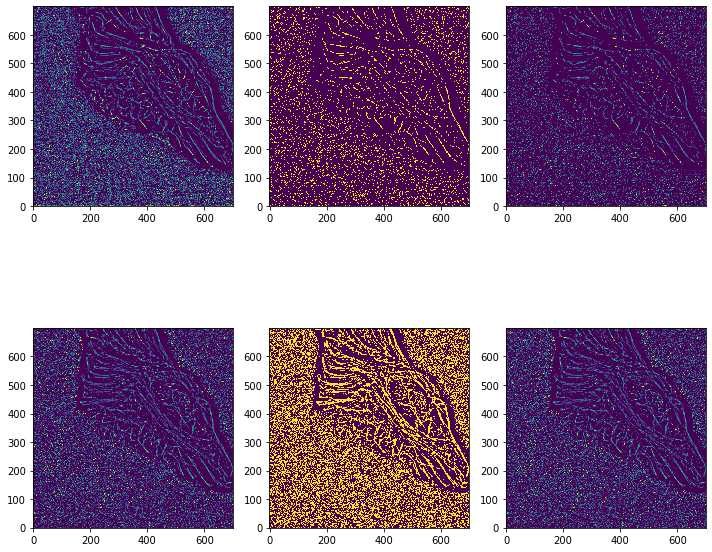

In [62]:
fig, ax = plt.subplots(2,3,figsize=(10,10))

ax[0,0].imshow(im[0], interpolation='none', origin='lower', vmin=0, vmax=10, cmap='viridis')
ax[1,0].imshow(im[1], interpolation='none', vmin=0, vmax=10, origin='lower', cmap='viridis')
ax[0,1].imshow(im_binary[0], interpolation='none', origin='lower', cmap='viridis')
ax[1,1].imshow(im_binary[1], interpolation='none', origin='lower', cmap='viridis')
ax[0,2].imshow(im_masked[0], interpolation='none', origin='lower', vmin=0, vmax=10, cmap='viridis')
ax[1,2].imshow(im_masked[1], interpolation='none', vmin=0, vmax=10, origin='lower', cmap='viridis')

plt.tight_layout()

In [32]:
Coloc = 'Colocalization'
metadata[Coloc] = coloc
results = metadata
results

,Date,Investigator,CH,Image No,[DCX] $(n M)$,Type,Colocalization
0,2022-02-28,Sofia,1,3,1.0,WT,0.169218


In [263]:
newdirectory = str(path.parents[0])+'//Colocalization_Data_Sheets'
newmydir = Path(newdirectory)
newmydir.mkdir(exist_ok=True)

In [264]:
results.to_csv(path/(investigator+'_'+date_today +'.csv'), encoding='utf-8', index=False)
results.to_csv(newmydir/(investigator+'_'+date_today+'.csv'), encoding='utf-8', index=False)

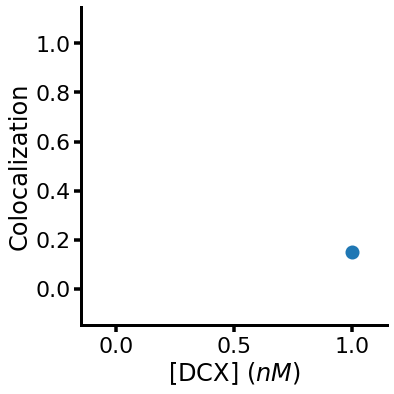

In [206]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.scatter(results[DCXconc], results[Coloc])
sns.despine()
sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})

ax.spines['left'].set_lw(3)
ax.spines['bottom'].set_lw(3)
ax.tick_params(axis='both', width = 3.5, length = 7)
ax.set_ylim(-0.15,1.15)
ax.set_xlim(-0.15,1.15)
ax.set_xlabel( DCXconc)
ax.set_ylabel(Coloc)

plt.tight_layout()

In [68]:
coeff_masked, pval = spy.stats.pearsonr(im_mts_cleaned.flatten(), im_dcx_masked.flatten())
coeff_otsu, pval = spy.stats.pearsonr(im_mts_cleaned.flatten(), im_dcx_otsu.flatten())
coeff_otsu_masked, pval = spy.stats.pearsonr(im_mts_cleaned.flatten(), im_dcx_otsu_masked.flatten())
coeff_masked, coeff_otsu, coeff_otsu_masked

(0.48384799516348004, 0.3387599598394834, 0.37688674000392214)